# Homework 4: Analyzing Rates of Sea Level Rise
In this homework, you'll investigate sea level change using data from the ECCO state estimate. You'll look at spatial differences over the past few decades and then compare how sea level on the California coast compares to the global mean.

Begin by importing the modules you'll need for this notebook:

In [1]:
# import packages here
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc4
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Part 1: Download Sea Surface Height Data
To begin this exercise, download all of the available sea surface height data (1992-2017) from the ECCO Version 4 Release 4 output. There are several different variables for sea surface height pertaining to different components and corrections. In this homework, we'll use the `SSHDYN` variable which is equivalent to what satellites would measure from space.

To obtain the data, use the [Downloading ECCO Data](https://github.com/ProfMikeWood/ocean_modeling_book/blob/main/tools/Downloading%20ECCO%20Data.ipynb) notebook provided with the course notes.

In [2]:
# define the path to the folder where the SSH data has been download on your machine
ssh_folder = '/Users/eddie/Documents/CS185C/Data'

## Part 2: Plot Total Sea Level Rise 1992-2017
As a first look into how sea level has changed in the past several decades, we'll look at the differences between two time periods at the beginning and end of the available model output: January 1992 and January 2017. It is important to use the same month because variations in sea level also have a seasonal cycle (as we'll see below). Begin by reading in the data:

In [15]:
# read in the longitude, latitude, and model ssh grid in January 1992 (SSHDYN_1992_01.nc)
jan1992_file = os.path.join(ssh_folder, 'ECCO', 'Version4', 'Release4', 'interp_monthly', 'SSHDYN', 'SSHDYN_1992_01.nc')
ds_jan1992 = xr.open_dataset(jan1992_file)
longitude = np.array(ds_jan1992['longitude'][:])  
latitude = np.array(ds_jan1992['latitude'][:])  
SSHDYN_jan1992 = np.array(ds_jan1992['SSHDYN'][:]).squeeze()  
ds_jan1992.close()

# read in the model ssh grid in January 2017 (SSHDYN_2017_01.nc)
jan2017_file = os.path.join(ssh_folder, 'ECCO', 'Version4', 'Release4', 'interp_monthly', 'SSHDYN', 'SSHDYN_2017_01.nc')
ds_jan2017 = xr.open_dataset(jan2017_file)
SSHDYN_jan2017 = np.array(ds_jan2017['SSHDYN'][:]).squeeze()  
ds_jan2017.close()


Now, make a plot of the difference between January 2017 and January 1992. Be sure to add a colorbar with a divergent colormaps and set the color bounds to be equal in the positive and negative directions.

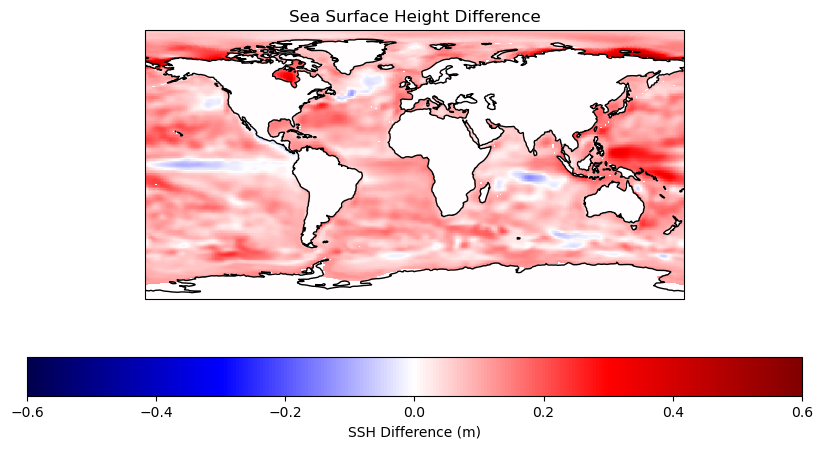

In [4]:
# make a plot of the differences between 2017 and 1992
ssh_difference = SSHDYN_jan2017 - SSHDYN_jan1992

lon, lat = np.meshgrid(longitude, latitude)

fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})
pcm = ax.pcolormesh(lon, lat, ssh_difference, vmin=-0.6, vmax=0.6, cmap='seismic')
ax.add_feature(cfeature.COASTLINE)

cbar = plt.colorbar(pcm, ax=ax, orientation='horizontal')
cbar.set_label('SSH Difference (m)')

ax.set_title('Sea Surface Height Difference')

plt.show()


### Questions:
Where are the largest increases in sea level observed between these two time periods? Are there any locations on the globe where sea level has fallen? If so, where?

Answer: The largest increases in sea level observed between these two periods are around the northern coastlines of Canada and Russia and the Pacific Ocean near Indonesia and surrounding islands. Some locations where sea levels have fallen are at the equator in the Pacific and Indian Ocean, the Atlantic Ocean directly under Greenland, and small patches above Antarctica. 

## Part 3: Create a Timeseries of Sea Surface Height in California
Next, we'll make a timeseries of sea surface height at a point off the California coast near San José. A close location in the model is at 37$^{\circ}$N, 122$^{\circ}$W. Begin by finding the closest row and column in the model grid to this longitude and latitude.

In [5]:
# define the latitude and longitude
lon = -122
lat = 37

# find the row and column closest to the location of the point off the CA coast
# note that you have already read in the longitude and latitude if the grid to make the plot above
lon_index = np.argmin(np.abs(longitude - lon))
lat_index = np.argmin(np.abs(latitude - lat))  


Now, armed with your sample location, loop through each sea surface height file to make a timeseries of sea level rise between 1992 and 2017. Every time you access a file, sample the model grid at the row and column you identified above.

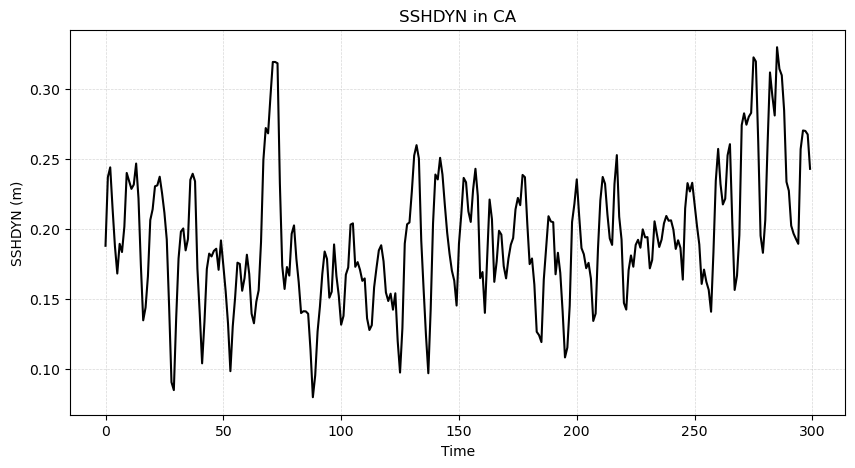

In [6]:
# File list setup
file_list = []

for year in range(1992, 2017):
    for month in range(1, 13): 
        file_name = 'SSHDYN_' + '{:04d}'.format(year) + '_' + '{:02d}'.format(month) + '.nc'
        file_list.append(file_name)

# Store SSH
SSHDYN_values_CA = []

for file_name in file_list:
    file_path = os.path.join(ssh_folder, 'ECCO', 'Version4', 'Release4', 'interp_monthly', 'SSHDYN', file_name)

    ds = xr.open_dataset(file_path)
    SSHDYN = np.array(ds['SSHDYN'][:]) 
    ds.close()

    ssh_value = SSHDYN[0, lat_index, lon_index] 
    SSHDYN_values_CA.append(ssh_value)
    
SSHDYN_values_CA = np.array(SSHDYN_values_CA)

# Create the plot
fig = plt.figure(figsize=(10, 5))
plt.plot(SSHDYN_values_CA, color='black')
plt.ylabel('SSHDYN (m)')
plt.xlabel('Time')
plt.title('SSHDYN in CA')

plt.grid(linestyle='--',linewidth=0.5,alpha=0.5)

plt.show()


## Part 4: Create a Timeseries of Global Mean Sea Surface Height
Next, make a timeseries of sea surface height averaged across the globe. Your loop should look quite similar to that above - you'll just need to make a slight change to average across the whole ocean rather than sampling at a single point.

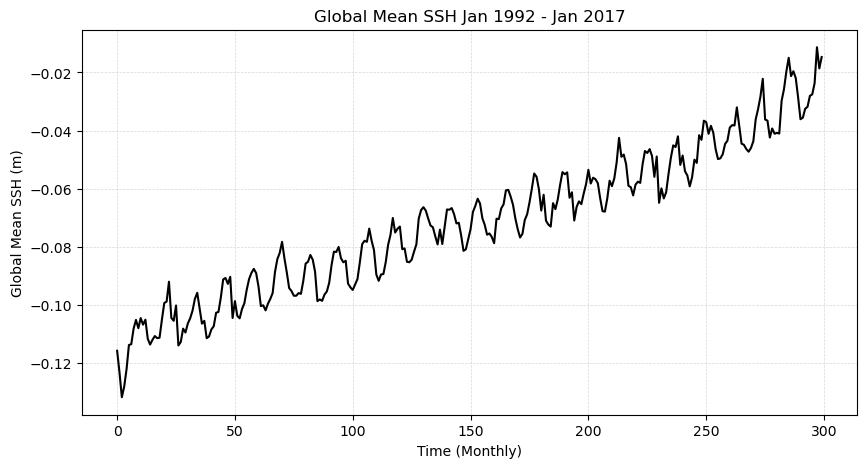

In [7]:
# create a timeseries of the global mean ssh by looping through all of the ssh files
# each time through the loop, take the mean of the ssh grid at the row and column identified above
# when you take the mean, be sure to exclude 0 values, which pertain to land
# your timeseries should be an (N,2) array with time in the first column and ssh values in the second

file_list = []

for year in range(1992, 2017):
    for month in range(1, 13): 
        file_name = 'SSHDYN_' + '{:04d}'.format(year) + '_' + '{:02d}'.format(month) + '.nc'
        file_list.append(file_name)

# Store SSH
SSHDYN_values_global = []

for file_name in file_list:
    file_path = os.path.join(ssh_folder, 'ECCO', 'Version4', 'Release4', 'interp_monthly', 'SSHDYN', file_name)

    ds = xr.open_dataset(file_path)
    SSHDYN = np.array(ds['SSHDYN'][:]) 
    ds.close()

    SSHDYN_sea = SSHDYN[SSHDYN != 0] 
    global_ssh = SSHDYN_sea.mean()

    SSHDYN_values_global.append(global_ssh)

SSHDYN_values_global = np.array(SSHDYN_values_global)

# Create the plot
fig = plt.figure(figsize=(10, 5))
plt.plot(SSHDYN_values_global, color='black')
plt.ylabel('Global Mean SSH (m)')
plt.xlabel('Time (Monthly)')
plt.title('Global Mean SSH Jan 1992 - Jan 2017')

plt.grid(linestyle='--', linewidth=0.5, alpha=0.5)

plt.show()


## Part 5: Compute Trends in Sea Surface Height
To compare the two timeseries, compute trends by fitting a line to each timeseries and examining the slope. Print out each trend in mm/yr, rounded to 2 decimal places. Note that the units of sea surface height are in meters.

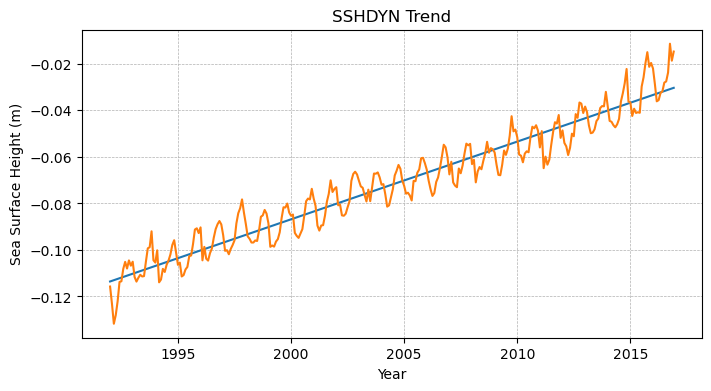

Slope: 3.34 mm/yr


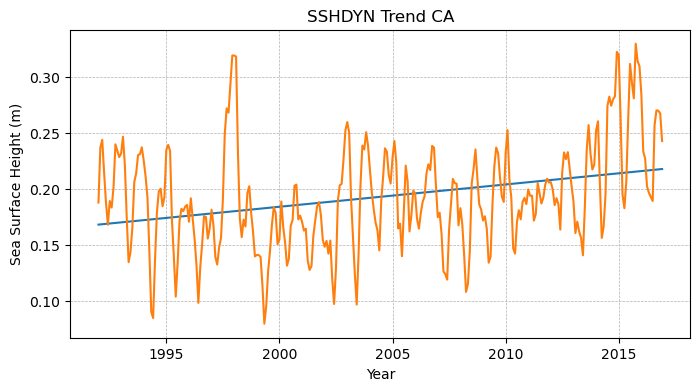

Slope: 1.99 mm/yr


In [8]:
# compute the trends in SLR by fitting a line to the CA and the global mean timeseries

# Global
months = np.arange(len(SSHDYN_values_global))
dec_yr = 1992 + months / 12
p = np.polyfit(dec_yr, SSHDYN_values_global, 1)

slope = p[0]  
intercept = p[1]  

# Create the plot
fig = plt.figure(figsize=(8, 4))

# line of best fit 
plt.plot(dec_yr, slope * dec_yr + intercept)

plt.plot(dec_yr, SSHDYN_values_global)
plt.title('SSHDYN Trend')
plt.ylabel('Sea Surface Height (m)')
plt.xlabel('Year')
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

# print out the statistics in mm/yr for each timeseries
print(f"Slope: {slope * 1000:.2f} mm/yr")

# CA
months = np.arange(len(SSHDYN_values_CA))
dec_yr = 1992 + months / 12
p = np.polyfit(dec_yr, SSHDYN_values_CA, 1)

slope = p[0]  
intercept = p[1]  

# Create the plot
fig = plt.figure(figsize=(8, 4))

# line of best fit 
plt.plot(dec_yr, slope * dec_yr + intercept)

plt.plot(dec_yr, SSHDYN_values_CA)
plt.title('SSHDYN Trend CA')
plt.ylabel('Sea Surface Height (m)')
plt.xlabel('Year')
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

# print out the statistics in mm/yr for each timeseries
print(f"Slope: {slope * 1000:.2f} mm/yr")

### Question:
How does the trend in sea level rise in California compare to the global mean rate?

Answer: The trend in sea level rise in CA is 1.99 mm/yr, which is much lower compared to the global trend of 3.34 mm/yr. Despite this, CA has a greater sea surface height. 

## Part 6: Plot the Timeseries of Sea Surface Height
Finally, plot the two timeseries on the same plot along with their trend lines. Be sure to label your axes and include a legend.

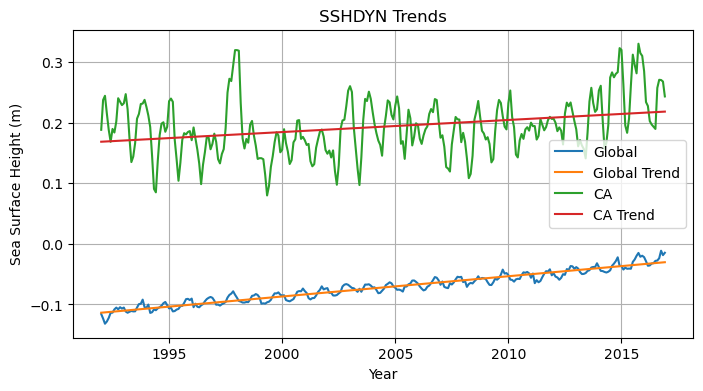

In [14]:
# Make a plot
fig, ax = plt.subplots(figsize=(8, 4))

# global
months_global = np.arange(len(SSHDYN_values_global))
dec_yr_global = 1992 + months_global / 12
p_global = np.polyfit(dec_yr_global, SSHDYN_values_global, 1)
slope_global, intercept_global = p_global
ax.plot(dec_yr_global, SSHDYN_values_global, label="Global")
ax.plot(dec_yr_global, slope_global * dec_yr_global + intercept_global, label=f"Global Trend")

# CA
months_ca = np.arange(len(SSHDYN_values_CA))
dec_yr_ca = 1992 + months_ca / 12
p_ca = np.polyfit(dec_yr_ca, SSHDYN_values_CA, 1)
slope_ca, intercept_ca = p_ca
ax.plot(dec_yr_ca, SSHDYN_values_CA, label="CA")
ax.plot(dec_yr_ca, slope_ca * dec_yr_ca + intercept_ca, label=f"CA Trend")

ax.set_title("SSHDYN Trends")
ax.set_ylabel("Sea Surface Height (m)")
ax.set_xlabel("Year")
ax.grid()
ax.legend()
plt.show()

### Questions:

How do the timeseries for Calfiornia and the global mean compare? Comment on their variability. What are the two highest years of sea level in California? What oceanographic phenomenon happened during this time?

Answer: The CA timeseries has more variability and a greater y-intercept but lesser slope for the trend line compared to the global mean. The two highest years of sea level in CA are around 1997 and 2016.  According to the National Weather Service, this was due to El Nino events, which cause warm water to expand. These events occurred in CA during 1983, 1997, and 2016. 

Source: https://www.weather.gov/media/sgx/hydro/CNAP_ElNino_Dec2015_FINAL.pdf